In [1]:
import pandas as pd 
import seaborn as sns
import numpy as np 
import pymc3 as pm 
import theano
import theano.tensor as tt
import arviz as az
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('../data/Covid-19 SG Clean.csv')
data['Date'] = pd.to_datetime(data['Date'], format="%d/%m/%Y")
data = data.sort_values('Date')

In [3]:
new_cases = data['Daily Confirmed '].values
len_observed = len(new_cases)

In [549]:
start_id = 50

local_cases = data['Daily Local transmission'].values[start_id:]
imported_cases = data['Daily Imported'].values[start_id:]
len_observed = len(local_cases)
print(len_observed)

448


### NPI Covariates

In [641]:
NPIS_proc = pd.read_csv('data/NPIS_LC_processed.csv')
NPIS_wanted = NPIS_proc.iloc[start_id:, 1::]

In [5]:
npi_series = data['Phase'].iloc[start_id:]
values_in_npi = npi_series.unique()

def check_nan(vals):
    for v in vals:
        if pd.isna(v):
            return True
    return False

if check_nan(values_in_npi):
    # NaN should be the base grou
    converted_npi =  pd.get_dummies(npi_series)
    print("None set as base class")

else:
    converted_npi = pd.get_dummies(npi_series)
    remove_var = converted_npi.columns[0]
    converted_npi = converted_npi.iloc[:,1:]
    print(remove_var + " set as base class")

None set as base class


# Singapore Testing Data from OWID

In [6]:
owid = pd.read_csv('../Data/owid-covid-data.csv')
singapore_testing = owid[owid['location']=='Singapore']
singapore_testing = singapore_testing[~singapore_testing['total_tests'].isna()][['date',
                                                                                 'total_tests',
                                                                                 'new_tests',
                                                                                 'positive_rate',
                                                                                 'tests_per_case']]

In [7]:
singapore_testing['test_done_in_week'] = singapore_testing['total_tests'].diff()
singapore_testing['average_test_daily'] = singapore_testing['test_done_in_week']/7.0

In [8]:
singapore_testing.tail()

,date,total_tests,new_tests,positive_rate,tests_per_case,test_done_in_week,average_test_daily
77579,2021-05-17,11064019.0,NaN,0.000,2647.8,622217.0,88888.142857
77586,2021-05-24,11470986.0,NaN,0.001,1647.6,406967.0,58138.142857
77593,2021-05-31,11947790.0,NaN,0.000,2496.3,476804.0,68114.857143
77600,2021-06-07,12366898.0,NaN,0.000,2636.0,419108.0,59872.571429
77607,2021-06-14,12809152.0,NaN,0.000,4859.9,442254.0,63179.142857


In [9]:
daily_dt_range = pd.date_range(start=singapore_testing['date'].iloc[0], end=singapore_testing['date'].iloc[-1])

In [10]:
singapore_testing_daily = singapore_testing.set_index('date')
singapore_testing_daily.index = pd.to_datetime(singapore_testing_daily.index)
singapore_testing_daily = singapore_testing_daily.reindex(daily_dt_range)

In [11]:
singapore_testing_daily['average_test_daily'] = singapore_testing_daily['average_test_daily'].bfill()

In [12]:
singapore_testing_daily = singapore_testing_daily.reset_index()
singapore_testing_daily = singapore_testing_daily.rename({'index':'Date'},axis=1)

In [13]:
singapore_testing_daily

,Date,total_tests,new_tests,positive_rate,tests_per_case,test_done_in_week,average_test_daily
0,2020-04-07,72680.0,NaN,NaN,NaN,NaN,3159.428571
1,2020-04-08,NaN,NaN,NaN,NaN,NaN,3159.428571
2,2020-04-09,NaN,NaN,NaN,NaN,NaN,3159.428571
3,2020-04-10,NaN,NaN,NaN,NaN,NaN,3159.428571
4,2020-04-11,NaN,NaN,NaN,NaN,NaN,3159.428571
...,...,...,...,...,...,...,...
429,2021-06-10,NaN,NaN,NaN,NaN,NaN,63179.142857
430,2021-06-11,NaN,NaN,NaN,NaN,NaN,63179.142857
431,2021-06-12,NaN,NaN,NaN,NaN,NaN,63179.142857
432,2021-06-13,NaN,NaN,NaN,NaN,NaN,63179.142857


In [14]:
data = data.merge(singapore_testing_daily[['Date','test_done_in_week','average_test_daily','positive_rate']],
                  on='Date',
                  how='left')

In [15]:
data['Daily_Positive_Rate_Estimate'] = data['Daily Confirmed ']/ data['average_test_daily']

<AxesSubplot:xlabel='Date'>

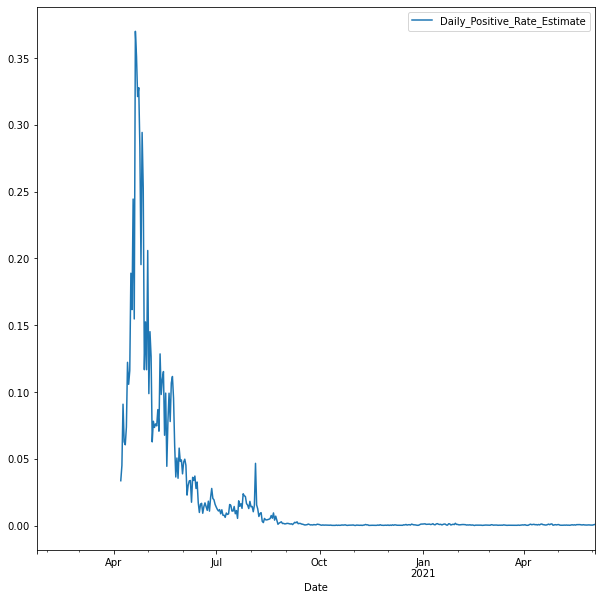

In [16]:
data.plot(x='Date', y='Daily_Positive_Rate_Estimate', figsize=(10,10))


<AxesSubplot:xlabel='Date'>

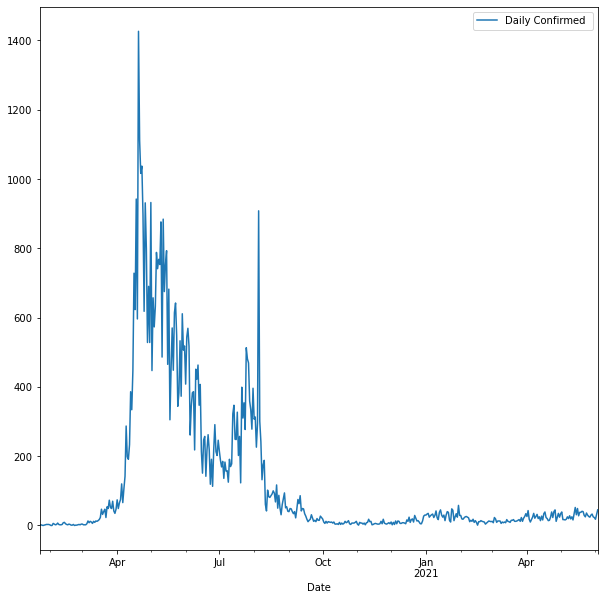

In [17]:
data.plot(x='Date',y='Daily Confirmed ', figsize=(10,10))

# Local Case Models

## Simple Model

In [591]:
with pm.Model() as model_r0:
    # r0 positive
    r0 = pm.Lognormal('r0', np.log(0.2), 0.1)
    
    # Seed pop
    seed = pm.Exponential('Seed', 0.01)
    y0 = tt.zeros(len_observed)
    y0 = tt.set_subtensor(y0[0], seed)
    # Apply recursively to populate tensor
    outputs, _ = theano.scan(
            fn=lambda t, y, r0: tt.set_subtensor(y[t], tt.sum(r0*y)),
            sequences=[tt.arange(1, len_observed)],
            outputs_info=y0,
            non_sequences=r0,
            n_steps=len_observed-1,
    )
    
    infections = pm.Deterministic('infections', outputs[-1])
    
    # Dont let infections become too large
    infections = tt.clip(infections, 0, 50000)
    
    # Likelihood
    pm.NegativeBinomial('Obs', 
              infections, 
              alpha=pm.Gamma("alpha", mu=6, sigma=1),
              observed=local_cases)
    
    trace_1 = pm.sample(chains=2, tune=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [alpha, Seed, r0]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 83 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [655]:
x = _get_generation_time_interval()

## Random Process Prior on R_t + Generation Time Dist

In [238]:
mean_si = 4.7
std_si = 2.9
mu_si = np.log(mean_si ** 2 / np.sqrt(std_si ** 2 + mean_si ** 2))
sigma_si = np.sqrt(np.log(std_si ** 2 / mean_si ** 2 + 1))
dist = sps.lognorm(scale=np.exp(mu_si), s=sigma_si)

In [246]:
lol = dist.pdf(np.linspace(0,19,200))

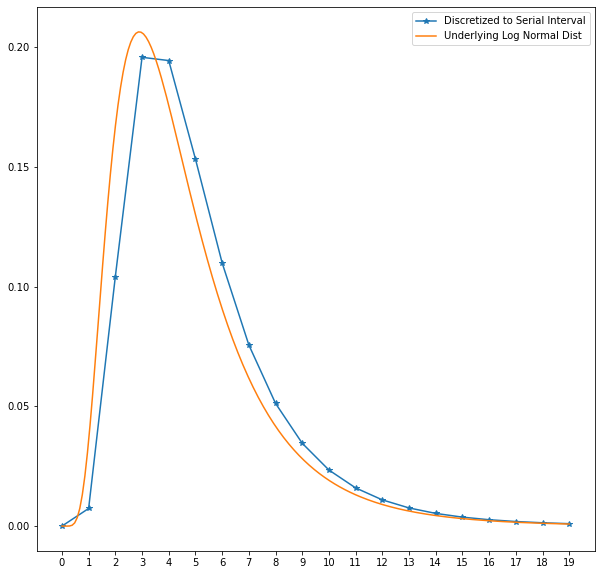

In [250]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(np.arange(len(a)),a, marker='*', label='Discretized to Serial Interval')
ax.plot(np.linspace(0,19,200), lol, label='Underlying Log Normal Dist')
ax.axes.set_xticks(np.arange(len(a)))
ax.legend()
plt.show()

In [161]:
from scipy import stats as sps

def _get_generation_time_interval():
    """ Create a discrete P(Generation Interval)
        Source: https://www.ijidonline.com/article/S1201-9712(20)30119-3/pdf """
    mean_si = 4.7
    std_si = 2.9
    mu_si = np.log(mean_si ** 2 / np.sqrt(std_si ** 2 + mean_si ** 2))
    sigma_si = np.sqrt(np.log(std_si ** 2 / mean_si ** 2 + 1))
    dist = sps.lognorm(scale=np.exp(mu_si), s=sigma_si)

    # Discretize the Generation Interval up to 20 days max
    g_range = np.arange(0, 20)
    gt = pd.Series(dist.cdf(g_range), index=g_range)
    gt = gt.diff().fillna(0)
    gt /= gt.sum()
    gt = gt.values
    return gt

def _get_convolution_ready_gt(len_observed):
    """ Speeds up theano.scan by pre-computing the generation time interval
        vector. Thank you to Junpeng Lao for this optimization.
        Please see the outbreak simulation math here:
        https://staff.math.su.se/hoehle/blog/2020/04/15/effectiveR0.html """
    gt = _get_generation_time_interval()
    convolution_ready_gt = np.zeros((len_observed - 1, len_observed))
    for t in range(1, len_observed):
        begin = np.maximum(0, t - len(gt) + 1)
        slice_update = gt[1 : t - begin + 1][::-1]
        convolution_ready_gt[
            t - 1, begin : begin + len(slice_update)
        ] = slice_update
    convolution_ready_gt = theano.shared(convolution_ready_gt)
    return convolution_ready_gt


In [658]:
convolution_ready_gt = _get_convolution_ready_gt(len_observed)
with pm.Model() as model_rt:
    # r0 positive
    log_r_t = pm.GaussianRandomWalk(
        'log_r_t',
        sigma=0.035,
        shape=len_observed)
    r_t = pm.Deterministic('r_t', pm.math.exp(log_r_t))
    
    # Seed pop
    seed = pm.Exponential('Seed', 1.5)
    y0 = tt.zeros(len_observed)
    y0 = tt.set_subtensor(y0[0], seed)
    # Apply recursively to populate tensor
    outputs, _ = theano.scan(
            fn=lambda t, gt, y, r_t: tt.set_subtensor(y[t], tt.sum(r_t*y*gt)),
            sequences=[tt.arange(1, len_observed), convolution_ready_gt],
            outputs_info=y0,
            non_sequences=r_t,
            n_steps=len_observed-1,
    )
    
    infections = pm.Deterministic('infections', outputs[-1])
    
    # Dont let infections become too large
    infections = tt.clip(infections, 0, 50000)
    
    # Likelihood
    pm.NegativeBinomial('Obs', 
              infections, 
              alpha=pm.Gamma("alpha", mu=1, sigma=0.5),
              observed=local_cases)
    
    trace_2 = pm.sample(chains=2, tune=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [alpha, Seed, log_r_t]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1786 seconds.


## Random Process Prior on R_t + Generation Time Dist + infection + positive onset delay dist

- Closest to Epidemia

In [18]:
from covid.patients import get_delay_distribution, get_delays_from_patient_data, download_patient_data
from theano.tensor.signal.conv import conv2d

In [19]:
x = get_delay_distribution()

In [20]:

delays = get_delays_from_patient_data(file_path='data/latestdata.csv')

In [89]:
np.ones(5)

array([1., 1., 1., 1., 1.])

In [106]:
INCUBATION_DAYS = 5

p_delay = delays.value_counts().sort_index()
new_range = np.arange(0, p_delay.index.max() + 1)
p_delay = p_delay.reindex(new_range, fill_value=0)
p_delay /= p_delay.sum()
p_delay = (
    pd.Series(0.0001*np.ones(INCUBATION_DAYS))
    .append(p_delay, ignore_index=True)
    .rename("p_delay")
)

In [107]:
#p_delay = delays.value_counts().sort_index()

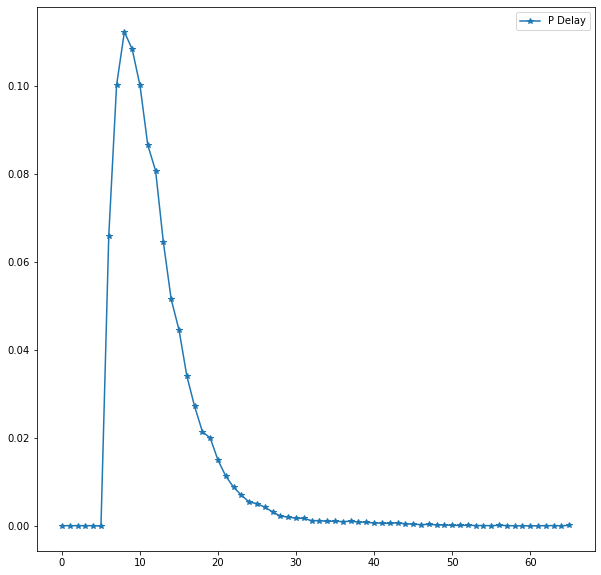

In [251]:
#p_delay = get_delay_distribution()
#p_delay = get_delay_distribution()
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(p_delay, marker='*', label='P Delay')
#ax.axes.set_xticks(np.arange(len(a)))
ax.legend()
plt.show()

In [109]:
p_delay

0     0.000100
1     0.000100
2     0.000100
3     0.000100
4     0.000100
        ...   
61    0.000078
62    0.000098
63    0.000117
64    0.000078
65    0.000163
Name: p_delay, Length: 66, dtype: float64

In [859]:
def conv(a, b, len_observed):
    "1D Convolution of a and b"
    from theano.tensor.signal.conv import conv2d
    return conv2d(
            tt.reshape(infections, (1, len_observed)),
            tt.reshape(p_delay, (1, len(p_delay))),
            border_mode='full',
            )[0, :len_observed]
    
#t_p_delay = pm.Data("p_delay", p_delay)

In [60]:
convolution_ready_gt = _get_convolution_ready_gt(len_observed)
with pm.Model() as model_rt:
    
    # r0 positive
    log_r_t = pm.GaussianRandomWalk(
        'log_r_t',
        sigma=0.035,
        shape=len_observed)
    r_t = pm.Deterministic('r_t', pm.math.exp(log_r_t))
    
    # Seed pop
    seed = pm.Exponential('Seed', 1.5)
    y0 = tt.zeros(len_observed)
    y0 = tt.set_subtensor(y0[0], seed)
    # Apply recursively to populate tensor
    outputs, _ = theano.scan(
            fn=lambda t, gt, y, r_t: tt.set_subtensor(y[t], tt.sum(r_t*y*gt)),
            sequences=[tt.arange(1, len_observed), convolution_ready_gt],
            outputs_info=y0,
            non_sequences=r_t,
            n_steps=len_observed-1,
    )
    
    infections = pm.Deterministic('infections', outputs[-1])
    
    # Dont let infections become too large
    infections = tt.clip(infections, 0, 50000)
    
    # Test observation
    #t_p_delay = pm.Data("p_delay", p_delay)
    
    test_adjusted_positive = pm.Deterministic(
        "test_adjusted_positive",
        conv2d(
            tt.reshape(infections, (1, len_observed)),
            tt.reshape(p_delay, (1, len(p_delay))),
            border_mode="full",
        )[0, :len_observed]
    )
    
    #test_adjusted_positive_print = tt.printing.Print("test_obs")(test_adjusted_positive)
    # Poisson with mu = 0 is degenerate this leads to issues
    test_adjusted_positive_jittered = pm.Deterministic('test_adjusted_positive_jit',
                                                       test_adjusted_positive+0.1)
    
    # Likelihood
    pm.NegativeBinomial('Obs', 
              test_adjusted_positive_jittered, 
              alpha=pm.Gamma("alpha", mu=1, sigma=0.5),
              observed=local_cases)
    
    trace_3 = pm.sample(chains=2, tune=500)

/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [alpha, Seed, log_r_t]


ValueError: Not enough samples to build a trace.

In [48]:
with pm.Model() as huh:
    
    #pm.NegativeBinomial('obs', [0,0,0,0], alpha=pm.Gamma("alpha", mu=1, sigma=0.5), observed=[4,3,5,6])
    obs = pm.Uniform('obs s',0,1, shape=4)
    obs_lol = pm.Deterministic('obs_0', 0*obs)
    pm.Poisson('obs', obs_lol, observed=[4,3,5,6])
    
    traceqw = pm.sample()

SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'obs s_interval__': array([0., 0., 0., 0.])}

Initial evaluation results:
obs s_interval__   -5.55
obs                 -inf
Name: Log-probability of test_point, dtype: float64

In [59]:
from scipy.stats import poisson
x = 1
mu = 0.1
poisson.pmf(x, mu)

0.09048374180359597

# Random Process Prior on R_t + Generation Time Dist + NPIs 

In [247]:
num_npi_covariates = len(converted_npi.columns)
print(num_npi_covariates)

5


In [388]:
(5000) * 1.2**5

12441.599999999997

In [248]:
convolution_ready_gt = _get_convolution_ready_gt(len_observed)
zinb = False
with pm.Model() as model_rt:
    
    # r0 positive
    log_r_t = pm.GaussianRandomWalk(
        'log_r_t',
        sigma=0.035,
        shape=len_observed)
    
    # Rt covariates
    beta_list = []
    for i in range(num_npi_covariates):
        beta_list.append(pm.Normal(f"b_{i}", 0, sigma=0.03))
    betas = pm.math.stack(beta_list, 0)
    beta_intercept = pm.Normal('b_inter', 0, sigma=0.03)
    rt_covariates = beta_intercept + pm.math.dot(np.array(converted_npi), betas)
    
    # Form r_t as GRW + covariates
    r_t = pm.Deterministic('r_t', pm.math.exp(log_r_t + rt_covariates))
    
    # Seed pop
    seed = pm.Exponential('Seed', 1.5)
    y0 = tt.zeros(len_observed)
    y0 = tt.set_subtensor(y0[0], seed)
    # Apply recursively to populate tensor
    outputs, _ = theano.scan(
            fn=lambda t, gt, y, r_t: tt.set_subtensor(y[t], tt.sum(r_t*y*gt)),
            sequences=[tt.arange(1, len_observed), convolution_ready_gt],
            outputs_info=y0,
            non_sequences=r_t,
            n_steps=len_observed-1,
    )
    
    infections = pm.Deterministic('infections', outputs[-1])
    
    # Dont let infections become too large
    infections = tt.clip(infections, 0, 50000)
    
    
    # Likelihood
    if zinb:
        pm.ZeroInflatedNegativeBinomial('Obs', 
                  mu=infections, 
                  alpha=pm.Gamma("alpha", mu=1, sigma=0.5),
                  psi = pm.Uniform(0,1),                    
                  observed=local_cases)    
    else:
        pm.NegativeBinomial('Obs', 
                  infections, 
                  alpha=pm.Gamma("alpha", mu=1, sigma=0.5),
                  observed=local_cases)
    
    trace_4 = pm.sample(chains=2, tune=500)

/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [alpha, Seed, b_inter, b_4, b_3, b_2, b_1, b_0, log_r_t]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 6799 seconds.
The acceptance probability does not match the target. It is 0.8840785280875413, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8962958268935288, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


# Random Process Prior on R_t + Generation Time Dist + NPIs + Zero inflated obs dist

In [249]:
convolution_ready_gt = _get_convolution_ready_gt(len_observed)
zinb = True
with pm.Model() as model_rt:
    
    # r0 positive
    log_r_t = pm.GaussianRandomWalk(
        'log_r_t',
        sigma=0.035,
        shape=len_observed)
    
    # Rt covariates
    beta_list = []
    for i in range(num_npi_covariates):
        beta_list.append(pm.Normal(f"b_{i}", 0, sigma=0.03))
    betas = pm.math.stack(beta_list, 0)
    beta_intercept = pm.Normal('b_inter', 0, sigma=0.1)
    rt_covariates = beta_intercept + pm.math.dot(np.array(converted_npi), betas)
    
    # Form r_t as GRW + covariates
    r_t = pm.Deterministic('r_t', pm.math.exp(log_r_t + rt_covariates))
    
    # Seed pop
    seed = pm.Exponential('Seed', 1.5)
    y0 = tt.zeros(len_observed)
    y0 = tt.set_subtensor(y0[0], seed)
    # Apply recursively to populate tensor
    outputs, _ = theano.scan(
            fn=lambda t, gt, y, r_t: tt.set_subtensor(y[t], tt.sum(r_t*y*gt)),
            sequences=[tt.arange(1, len_observed), convolution_ready_gt],
            outputs_info=y0,
            non_sequences=r_t,
            n_steps=len_observed-1,
    )
    
    infections = pm.Deterministic('infections', outputs[-1])
    
    # Dont let infections become too large
    infections = tt.clip(infections, 0, 50000)
    
    
    # Likelihood
    if zinb:
        pm.ZeroInflatedNegativeBinomial('Obs', 
                  mu=infections, 
                  alpha=pm.Gamma("alpha", mu=1, sigma=0.5),
                  psi = pm.Beta('psi', 2,2),                    
                  observed=local_cases)    
    else:
        pm.NegativeBinomial('Obs', 
                  infections, 
                  alpha=pm.Gamma("alpha", mu=1, sigma=0.5),
                  observed=local_cases)
    
    trace_5 = pm.sample(chains=2, tune=1000, target_accept=0.99)

/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [psi, alpha, Seed, b_inter, b_4, b_3, b_2, b_1, b_0, log_r_t]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 18496 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


# Random Process Prior on R_t + Generation Time Dist + NPIs + Onset Delay Dist + Adjusting Tests Performed

In [61]:
#data_subset = data[~data['average_test_daily'].isna()]

In [62]:
local_cases = data['Daily Local transmission'].values[start_id:]
imported_cases = data['Daily Imported'].values[start_id:]
len_observed = len(local_cases)
print(len_observed)

tests_performed = data['average_test_daily'].iloc[start_id:].fillna(0).values

448


In [63]:
npi_series = data['Phase'].iloc[start_id:]
values_in_npi = npi_series.unique()

def check_nan(vals):
    for v in vals:
        if pd.isna(v):
            return True
    return False

if check_nan(values_in_npi):
    # NaN should be the base grou
    converted_npi =  pd.get_dummies(npi_series)
    print("None set as base class")

else:
    converted_npi = pd.get_dummies(npi_series)
    remove_var = converted_npi.columns[0]
    converted_npi = converted_npi.iloc[:,1:]
    print(remove_var + " set as base class")

num_npi_covariates = len(converted_npi.columns)

None set as base class


In [122]:
convolution_ready_gt = _get_convolution_ready_gt(len_observed)

likelihood_fun = 'PO' # PO or ZINB
with pm.Model() as model_rt:
    
    # r0 positive
    log_r_t = pm.GaussianRandomWalk(
        'log_r_t',
        sigma=0.035,
        shape=len_observed)
    
    # Rt covariates
    beta_list = []
    for i in range(num_npi_covariates):
        beta_list.append(pm.Normal(f"b_{i}", 0, sigma=0.03))
    betas = pm.math.stack(beta_list, 0)
    beta_intercept = pm.Normal('b_inter', 0, sigma=0.1)
    rt_covariates = beta_intercept + pm.math.dot(np.array(converted_npi), betas)
    
    # Form r_t as GRW + covariates
    r_t = pm.Deterministic('r_t', pm.math.exp(log_r_t + rt_covariates))
    
    # Seed pop
    seed = pm.Exponential('Seed', 150)  # Scale of infection will be small
    y0 = tt.zeros(len_observed)
    y0 = tt.set_subtensor(y0[0], seed)
    # Apply recursively to populate tensor
    outputs, _ = theano.scan(
            fn=lambda t, gt, y, r_t: tt.set_subtensor(y[t], tt.sum(r_t*y*gt)),
            sequences=[tt.arange(1, len_observed), convolution_ready_gt],
            outputs_info=y0,
            non_sequences=r_t,
            n_steps=len_observed-1,
    )
    
    infections = pm.Deterministic('infections', outputs[-1])
    
    
    # Test observation
    t_p_delay = pm.Data("p_delay", p_delay)
    
    test_adjusted_positive = pm.Deterministic(
        "test adjusted positive",
        conv(infections, t_p_delay, len_observed)
    )
    
    # For stability
    test_adjusted_positive_jittered = pm.Deterministic('test_adjusted_positive_jit',
                                                   test_adjusted_positive + 0.01)
    
    # Accounts for number of tests 
    # Get number of tests
    tests = pm.Data("tests", tests_performed)
    exposure = pm.Deterministic(
        "exposure",
        pm.math.clip(tests_performed, 1000, 1e9)  # Hard code to 300 test a day for unobs period
    )
    
    positive = pm.Deterministic(
        "positive", exposure * test_adjusted_positive_jittered
    )
    
    
    # Likelihood
    if likelihood_fun == 'ZINB':
        pm.ZeroInflatedNegativeBinomial('Obs', 
                  mu=positive, 
                  alpha=pm.Gamma("alpha", mu=1, sigma=0.5),
                  psi = pm.Beta('psi', 2,2),                    
                  observed=local_cases)    
        
    elif likelihood_fun == 'NB':
        pm.NegativeBinomial('Obs', 
                  mu=positive, 
                  alpha=pm.Gamma("alpha", mu=1, sigma=0.5),
                  observed=local_cases)
    
    elif likelihood_fun == 'PO':
        print('hi')
        pm.Poisson('Obs', 
                  mu=positive,
                  observed=local_cases)
    
    trace_6 = pm.sample(chains=2, tune=500, init="adapt_diag")#, target_accept=0.99)

hi


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [Seed, b_inter, b_4, b_3, b_2, b_1, b_0, log_r_t]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 9490 seconds.
The acceptance probability does not match the target. It is 0.8913084151778055, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


# Random Process Prior on R_t + Generation Time Dist + NPIs + Onset Delay Dist + alpha_t

- Most Similar to Epidemia

In [529]:
convolution_ready_gt = _get_convolution_ready_gt(len_observed)

zinb = False
with pm.Model() as model_rt:
    
    # r0 positive
    log_r_t = pm.GaussianRandomWalk(
        'log_r_t',
        sigma=0.035,
        shape=len_observed)
    
    # Rt covariates
    beta_list = []
    for i in range(num_npi_covariates):
        beta_list.append(pm.Normal(f"b_{i}", 0, sigma=0.03))
    betas = pm.math.stack(beta_list, 0)
    beta_intercept = pm.Normal('b_inter', 0, sigma=0.1)
    rt_covariates = beta_intercept + pm.math.dot(np.array(converted_npi), betas)
    
    # Form r_t as GRW + covariates
    r_t = pm.Deterministic('r_t', pm.math.exp(log_r_t + rt_covariates))
    
    # Seed pop
    seed = pm.Exponential('Seed', 1.5)
    y0 = tt.zeros(len_observed)
    y0 = tt.set_subtensor(y0[0], seed)
    # Apply recursively to populate tensor
    outputs, _ = theano.scan(
            fn=lambda t, gt, y, r_t: tt.set_subtensor(y[t], tt.sum(r_t*y*gt)),
            sequences=[tt.arange(1, len_observed), convolution_ready_gt],
            outputs_info=y0,
            non_sequences=r_t,
            n_steps=len_observed-1,
    )
    
    infections = pm.Deterministic('infections', outputs[-1])
    
    # Dont let infections become too large
    infections = tt.clip(infections, 0, 50000)
    
    
    # Test observation
    t_p_delay = pm.Data("p_delay", p_delay)
    
    log_alpha_t = pm.GaussianRandomWalk(
        'log_a_t',
        sigma=0.035,
        shape=len_observed)
    alpha_t = pm.Deterministic('a_t', pm.math.exp(log_alpha_t))
    
    
    test_adjusted_positive = pm.Deterministic(
        "test adjusted positive",
        conv(infections, t_p_delay, len_observed)
    )
    
    
    positive = pm.Deterministic(
        "positive", alpha_t * test_adjusted_positive
    )
    
    
    # Likelihood
    if zinb:
        pm.ZeroInflatedNegativeBinomial('Obs', 
                  mu=positive, 
                  alpha=pm.Gamma("alpha", mu=1, sigma=0.5),
                  psi = pm.Beta('psi', 2,2),                    
                  observed=local_cases)    
    else:
        pm.NegativeBinomial('Obs', 
                  mu=positive, 
                  alpha=pm.Gamma("alpha", mu=1, sigma=0.5),
                  observed=local_cases)
    
    trace_7 = pm.sample(chains=2, tune=500)#, target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [alpha, log_a_t, Seed, b_inter, b_4, b_3, b_2, b_1, b_0, log_r_t]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 12116 seconds.
The acceptance probability does not match the target. It is 0.8996988495009262, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 701 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


# Random Process Prior on R_t + Generation Time Dist + Onset Delay Dist + Adjusting Tests Performed + Imported Cases

In [134]:
data.columns

Index(['Date', 'Daily Confirmed ', 'False Positives Found',
       'Cumulative Confirmed', 'Daily Discharged',
       'Passed but not due to COVID', 'Cumulative Discharged',
       'Discharged to Isolation', 'Still Hospitalised', 'Daily Deaths',
       'Cumulative Deaths', 'Tested positive demise', 'Daily Imported',
       'Daily Local transmission', 'Local cases residing in dorms MOH report',
       'Local cases not residing in doms MOH report',
       'Intensive Care Unit (ICU)', 'General Wards MOH report',
       'In Isolation MOH report', 'Total Completed Isolation MOH report',
       'Total Hospital Discharged MOH report', 'Linked community cases',
       'Unlinked community cases', 'Phase', 'test_done_in_week',
       'average_test_daily', 'positive_rate', 'Daily_Positive_Rate_Estimate'],
      dtype='object')

In [135]:
imported_cases = data['Daily Imported'].values[start_id:]

In [141]:
convolution_ready_gt.values()|

SyntaxError: invalid syntax (<ipython-input-141-5244a44e82a9>, line 1)

In [214]:
convolution_ready_gt = _get_convolution_ready_gt(len_observed)

likelihood_fun = 'PO' # PO or ZINB
with pm.Model() as model_8:
    
    # r0 positive
    log_r_t = pm.GaussianRandomWalk(
        'log_r_t',
        sigma=0.035,
        shape=len_observed)
    
    # Form r_t as GRW + covariates
    r_t = pm.Deterministic('r_t', pm.math.exp(log_r_t))
    
        
    # Imported cases leak percent
    log_eps_t = pm.GaussianRandomWalk(
        'log_eps_t',
        sigma=0.035,
        shape=len_observed)
    #eps_t = pm.Deterministic('eps_t', pm.math.exp(log_eps_t))
    eps_t = pm.Beta('eps_t', alpha=1, beta=1000)
    
    # Seed pop
    seed = pm.Exponential('Seed', 150)  # Scale of infection will be small
    y0 = tt.zeros(len_observed)
    y0 = tt.set_subtensor(y0[0], seed)
    # Apply recursively to populate tensor
    outputs, _ = theano.scan(
            fn=lambda t, gt , i_cases, y, r_t: tt.set_subtensor(y[t], tt.sum(r_t*y*gt) + eps_t * i_cases),
            sequences=[tt.arange(1, len_observed), convolution_ready_gt, theano.shared(imported_cases)],
            outputs_info=y0,
            non_sequences=r_t,
            n_steps=len_observed-1,
    )
    
    infections = pm.Deterministic('infections', outputs[-1])
    
    
    
    # Test observation
    t_p_delay = pm.Data("p_delay", p_delay)
    
    test_adjusted_positive = pm.Deterministic(
        "test adjusted positive",
        conv(infections, t_p_delay, len_observed)
    )
    
    # For stability
    test_adjusted_positive_jittered = pm.Deterministic('test_adjusted_positive_jit',
                                                   test_adjusted_positive + 0.01)
    
    # Accounts for number of tests 
    # Get number of tests
    tests = pm.Data("tests", tests_performed)
    exposure = pm.Deterministic(
        "exposure",
        pm.math.clip(tests_performed, 1000, 1e9)  # Hard code to 300 test a day for unobs period
    )
    
    positive = pm.Deterministic(
        "positive", exposure * test_adjusted_positive_jittered
    )
    
    
    # Likelihood
    if likelihood_fun == 'ZINB':
        pm.ZeroInflatedNegativeBinomial('Obs', 
                  mu=positive, 
                  alpha=pm.Gamma("alpha", mu=1, sigma=0.5),
                  psi = pm.Beta('psi', 2,2),                    
                  observed=local_cases)    
        
    elif likelihood_fun == 'NB':
        pm.NegativeBinomial('Obs', 
                  mu=positive, 
                  alpha=pm.Gamma("alpha", mu=1, sigma=0.5),
                  observed=local_cases)
    
    elif likelihood_fun == 'PO':
        print('hi')
        pm.Poisson('Obs', 
                  mu=positive,
                  observed=local_cases)
    
    trace_8 = pm.sample(chains=2, tune=1000, draws=2000, init="adapt_diag", target_accept=0.99)

hi


/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [Seed, eps_t, log_eps_t, log_r_t]


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 24828 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


# Model 9, Model 8 but without test adjustedment

In [216]:
convolution_ready_gt = _get_convolution_ready_gt(len_observed)

likelihood_fun = 'PO' # PO or ZINB
with pm.Model() as model_9:
    
    # r0 positive
    log_r_t = pm.GaussianRandomWalk(
        'log_r_t',
        sigma=0.035,
        shape=len_observed)
    
    # Form r_t as GRW + covariates
    r_t = pm.Deterministic('r_t', pm.math.exp(log_r_t))
    
        
    # Imported cases leak percent
    log_eps_t = pm.GaussianRandomWalk(
        'log_eps_t',
        sigma=0.035,
        shape=len_observed)
    #eps_t = pm.Deterministic('eps_t', pm.math.exp(log_eps_t))
    eps_t = pm.Beta('eps_t', alpha=1, beta=1000)
    
    # Seed pop
    seed = pm.Exponential('Seed', 150)  # Scale of infection will be small
    y0 = tt.zeros(len_observed)
    y0 = tt.set_subtensor(y0[0], seed)
    # Apply recursively to populate tensor
    outputs, _ = theano.scan(
            fn=lambda t, gt , i_cases, y, r_t: tt.set_subtensor(y[t], tt.sum(r_t*y*gt) + eps_t * i_cases),
            sequences=[tt.arange(1, len_observed), convolution_ready_gt, theano.shared(imported_cases)],
            outputs_info=y0,
            non_sequences=r_t,
            n_steps=len_observed-1,
    )
    
    infections = pm.Deterministic('infections', outputs[-1])
    
    
    
    # Test observation
    t_p_delay = pm.Data("p_delay", p_delay)
    
    test_adjusted_positive = pm.Deterministic(
        "test adjusted positive",
        conv(infections, t_p_delay, len_observed)
    )
    
    # For stability
    test_adjusted_positive_jittered = pm.Deterministic('test_adjusted_positive_jit',
                                                   test_adjusted_positive + 0)
    """
    # Accounts for number of tests 
    # Get number of tests
    tests = pm.Data("tests", tests_performed)
    exposure = pm.Deterministic(
        "exposure",
        pm.math.clip(tests_performed, 1000, 1e9)  # Hard code to 300 test a day for unobs period
    )
    
    positive = pm.Deterministic(
        "positive", exposure * test_adjusted_positive_jittered
    )
    """
    
    # Likelihood
    if likelihood_fun == 'ZINB':
        pm.ZeroInflatedNegativeBinomial('Obs', 
                  mu=test_adjusted_positive_jittered, 
                  alpha=pm.Gamma("alpha", mu=1, sigma=0.5),
                  psi = pm.Beta('psi', 2,2),                    
                  observed=local_cases)    
        
    elif likelihood_fun == 'NB':
        pm.NegativeBinomial('Obs', 
                  mu=test_adjusted_positive_jittered, 
                  alpha=pm.Gamma("alpha", mu=1, sigma=0.5),
                  observed=local_cases)
    
    elif likelihood_fun == 'PO':
        print('hi')
        pm.Poisson('Obs', 
                  mu=test_adjusted_positive_jittered,
                  observed=local_cases)
    
    trace_9 = pm.sample(chains=2, tune=1000, draws=2000)#, target_accept=0.99)

hi


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [Seed, eps_t, log_eps_t, log_r_t]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 26882 seconds.
The acceptance probability does not match the target. It is 0.915318239949875, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


# Model 10 - Model 9 but with prediction using pymc3 inbuilt interpolate

In [857]:
print("Length import Cases: ",len(imported_cases))
print("Length local Cases: ", len(local_cases))

prediction_t = 7 # Days
end_date = 410+7
train_local_cases = local_cases[0:end_date]
train_imported_cases = imported_cases[0:end_date]

actual = local_cases[end_date:end_date+prediction_t]

train_pad = [np.nan for x in range(prediction_t)]
imported_pad = [train_imported_cases[-1] for x in range(prediction_t)]

model_input = pd.Series(np.concatenate([train_local_cases, train_pad]))
imported_input = np.concatenate([train_imported_cases, imported_pad])

print("Length training cases: ", len(train_local_cases))
print("Length into model: ", len(model_input)," ",len(imported_input))

len_observed = len(model_input)

Length import Cases:  448
Length local Cases:  448
Length training cases:  417
Length into model:  424   424


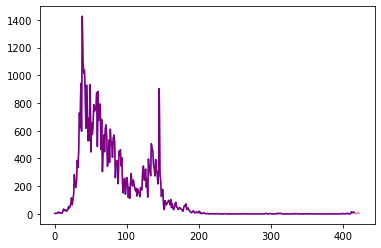

In [858]:
plt.plot(train_local_cases, c='b')
plt.plot(np.concatenate([train_local_cases, actual]), c='r', alpha=0.5)

In [813]:
convolution_ready_gt = _get_convolution_ready_gt(len_observed)

likelihood_fun = 'PO' # PO or ZINB
with pm.Model() as model_10:
    
    # r0 positive
    log_r_t = pm.GaussianRandomWalk(
        'log_r_t',
        sigma=0.035,
        shape=len_observed)
    
    # Form r_t as GRW + covariates
    r_t = pm.Deterministic('r_t', pm.math.exp(log_r_t))
    
        
    # Imported cases leak percent
    log_eps_t = pm.GaussianRandomWalk(
        'log_eps_t',
        sigma=0.035,
        shape=len_observed)
    #eps_t = pm.Deterministic('eps_t', pm.math.exp(log_eps_t))
    eps_t = pm.Beta('eps_t', alpha=1, beta=1000)
    
    # Seed pop
    seed = pm.Exponential('Seed', 150)  # Scale of infection will be small
    y0 = tt.zeros(len_observed)
    y0 = tt.set_subtensor(y0[0], seed)
    # Apply recursively to populate tensor
    outputs, _ = theano.scan(
            fn=lambda t, gt , i_cases, y, r_t: tt.set_subtensor(y[t], tt.sum(r_t*y*gt) + eps_t * i_cases),
            sequences=[tt.arange(1, len_observed), convolution_ready_gt, theano.shared(imported_input)],
            outputs_info=y0,
            non_sequences=r_t,
            n_steps=len_observed-1,
    )
    
    infections = pm.Deterministic('infections', outputs[-1])
    
    
    
    # Test observation
    t_p_delay = pm.Data("p_delay", p_delay)
    
    test_adjusted_positive = pm.Deterministic(
        "test adjusted positive",
        conv(infections, t_p_delay, len_observed)
    )
    
    # For stability
    test_adjusted_positive_jittered = pm.Deterministic('test_adjusted_positive_jit',
                                                   test_adjusted_positive + 0)
    """
    # Accounts for number of tests 
    # Get number of tests
    tests = pm.Data("tests", tests_performed)
    exposure = pm.Deterministic(
        "exposure",
        pm.math.clip(tests_performed, 1000, 1e9)  # Hard code to 300 test a day for unobs period
    )
    
    positive = pm.Deterministic(
        "positive", exposure * test_adjusted_positive_jittered
    )
    """
    
    # Likelihood
    if likelihood_fun == 'ZINB':
        pm.ZeroInflatedNegativeBinomial('Obs', 
                  mu=test_adjusted_positive_jittered, 
                  alpha=pm.Gamma("alpha", mu=1, sigma=0.5),
                  psi = pm.Beta('psi', 2,2),                    
                  observed=local_cases)    
        
    elif likelihood_fun == 'NB':
        pm.NegativeBinomial('Obs', 
                  mu=test_adjusted_positive_jittered, 
                  alpha=pm.Gamma("alpha", mu=1, sigma=0.5),
                  observed=local_cases)
    
    elif likelihood_fun == 'PO':
        print('hi')
        pm.Poisson('Obs', 
                  mu=test_adjusted_positive_jittered,
                  observed=model_input)
    
    trace_10 = pm.sample(chains=2, tune=2000, draws=4000)#, target_accept=0.99)

FileNotFoundError: [Errno 2] No such file or directory: '/home/tzehong/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.31-x86_64-3.9.2-64/tmpbyn4jwzu/key.pkl'

In [448]:
trace_10['Obs_missing']

array([[184, 174, 166, ..., 149, 128, 165],
       [183, 173, 163, ..., 150, 124, 161],
       [183, 173, 163, ..., 150, 124, 161],
       ...,
       [171, 161, 180, ..., 139, 137, 146],
       [171, 161, 180, ..., 139, 137, 146],
       [171, 161, 180, ..., 139, 137, 146]])

In [ ]:
_, n_traces = trace_10['Obs_missing'].T.shape
temp_dates = np.arange(end_date, end_date+prediction_t).reshape(-1,1)
temp_dates = np.tile(temp_dates,n_traces)

In [495]:
with model_10:
    ppc_10 = pm.sample_posterior_predictive(
        trace_10, random_seed=123)

In [503]:
ppc_10['Obs'].mean(0)[115:]

array([171.16325 , 167.29925 , 163.03825 , 158.923125, 154.689375,
       150.421625, 146.335   , 142.41725 , 138.23275 , 134.434625])

In [504]:
trace_10['Obs_missing'].mean(0)

array([172.07625 , 167.773125, 163.5375  , 159.087   , 153.16125 ,
       150.053875, 146.5985  , 140.771875, 138.4345  , 133.755   ])

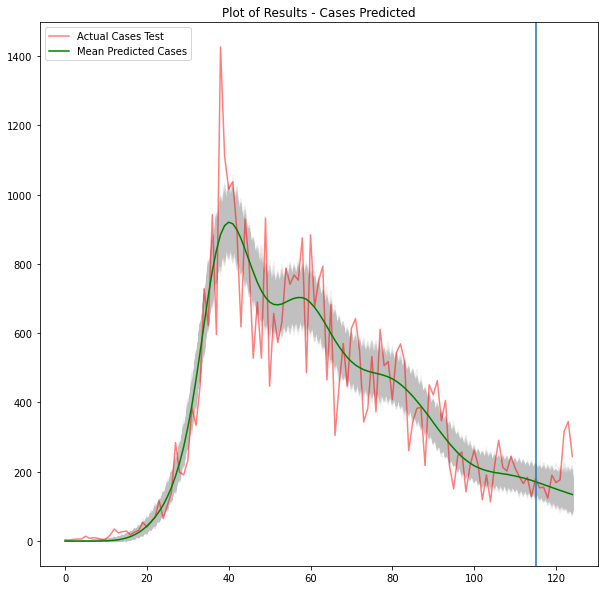

In [511]:
fig, ax = plt.subplots(figsize=(10,10))

#ax.plot(train_local_cases, c='b', label='Local Cases')
#ax.plot(temp_dates, trace_10['Obs_missing'].T, c='silver', alpha=0.2)
ax.plot(ppc_10['Obs'].T, c='silver', alpha=0.2)

ax.plot(np.concatenate([train_local_cases, actual]), c='r', alpha=0.5, label='Actual Cases Test')
ax.plot(ppc_10['Obs'].mean(0), c='g', alpha=1, label='Mean Predicted Cases')
ax.axvline(x=end_date)
ax.set_title("Plot of Results - Cases Predicted")
ax.legend()
plt.show()

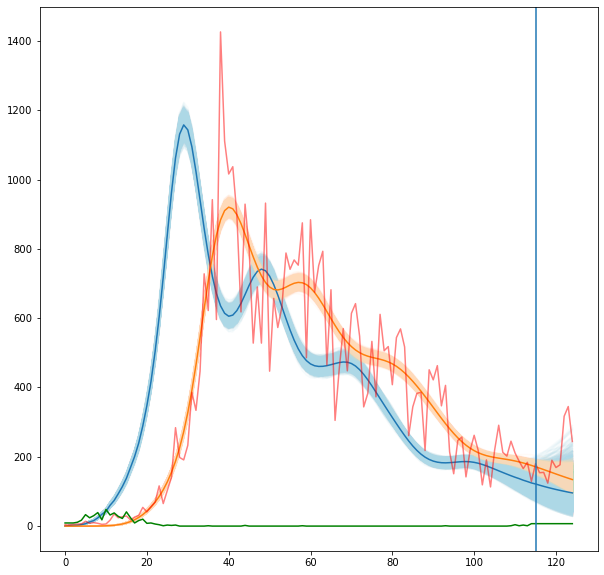

In [536]:
fig, ax = plt.subplots(figsize=(10,10))

ax.plot(trace_10['infections'].T, c='lightblue', alpha=0.1)
ax.plot(trace_10['test_adjusted_positive_jit'].T, c='peachpuff', alpha=0.1)
ax.plot(trace_10['infections'].mean(0))
ax.plot(trace_10['test_adjusted_positive_jit'].mean(0))
ax.plot(np.concatenate([train_local_cases, actual]), c='r', alpha=0.5)
ax.plot(imported_input, c='g')
ax.axvline(x=end_date)

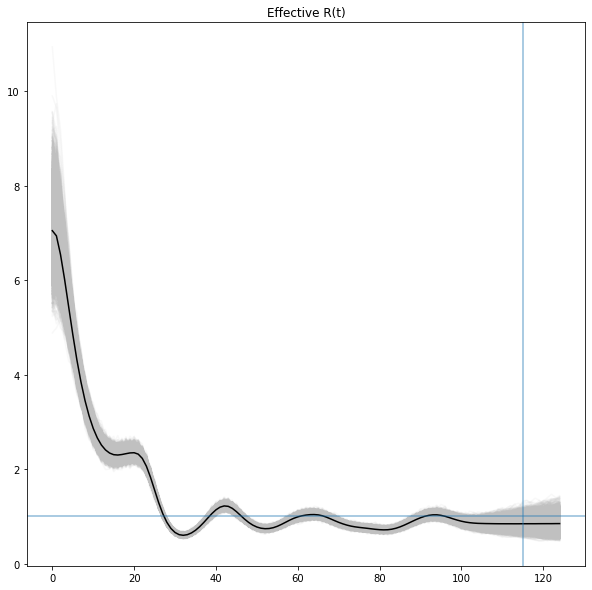

In [524]:
fig, ax = plt.subplots(figsize=(10,10))

ax.plot(trace_10['r_t'].T, c='silver', alpha=0.1)
ax.plot(trace_10['r_t'].mean(0), c='black', alpha=1)
ax.axhline(y=1, alpha=0.5)
ax.axvline(x=end_date, alpha=0.5)
ax.set_title("Effective R(t)")
plt.show()

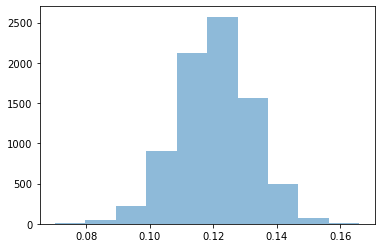

In [533]:
plt.hist(trace_10['eps_t'], alpha=0.5)
plt.show()

In [538]:
imported_input

array([ 9,  9,  9, 11, 17, 33, 24, 30, 39, 18, 48, 32, 38, 28, 22, 41, 24,
        9, 16, 20,  8,  9,  6,  4,  1,  3,  2,  3,  0,  0,  0,  0,  0,  0,
        0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  1,  4,  1,  3,  1,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7])

# Model 11 - Model 10 but with NPIs

In [645]:
print("Length import Cases: ",len(imported_cases))
print("Length local Cases: ", len(local_cases))

prediction_t = 10 # Days
end_date = 115

train_local_cases = local_cases[0:end_date]
train_imported_cases = imported_cases[0:end_date]

actual = local_cases[end_date:end_date+prediction_t]

train_pad = [np.nan for x in range(prediction_t)]
imported_pad = [train_imported_cases[-1] for x in range(prediction_t)]

model_input = pd.Series(np.concatenate([train_local_cases, train_pad]))
imported_input = np.concatenate([train_imported_cases, imported_pad])

print("Length training cases: ", len(train_local_cases))
print("Length into model: ", len(model_input)," ",len(imported_input))

len_observed = len(model_input)

Length import Cases:  448
Length local Cases:  448
Length training cases:  115
Length into model:  125   125


In [669]:
NPIS_proc = pd.read_csv('data/NPIS_LC_processed.csv')
NPIS_wanted = NPIS_proc.iloc[start_id:, 1::]

In [670]:
NPIS_array = NPIS_wanted.iloc[0:end_date+prediction_t]
NPIS_array.loc[NPIS_array['Gathering_Max']==150,'Gathering_Max'] = 10
NPIS_array = NPIS_array.values
#num_NPIS = NPIS_array.shape[1]
print(NPIS_array.shape)

(125, 10)


/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


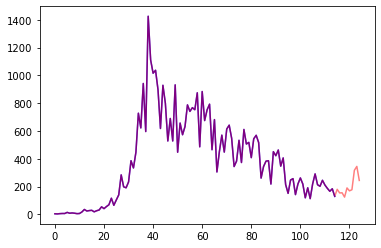

In [672]:
plt.plot(train_local_cases, c='b')
plt.plot(np.concatenate([train_local_cases, actual]), c='r', alpha=0.5)

In [674]:
convolution_ready_gt = _get_convolution_ready_gt(len_observed)

likelihood_fun = 'PO' # PO or ZINB
with pm.Model() as model_11:
    
    # r0 positive
    log_r_t = pm.GaussianRandomWalk(
        'log_r_t',
        sigma=0.035,
        shape=len_observed)
    
    beta_list = []
    for i in range(num_NPIS):
        beta_list.append(pm.Normal(f"b_{i}", 0, sigma=0.03))
    betas = pm.math.stack(beta_list, 0)
    #beta_intercept = pm.Normal('b_inter', 0, sigma=0.1)
    rt_covariates = pm.math.dot(np.array(NPIS_array), betas)
    
    
    # Form r_t as GRW + covariates
    r_t = pm.Deterministic('r_t', pm.math.exp(log_r_t + rt_covariates))
    
        
    # Imported cases leak percent
    log_eps_t = pm.GaussianRandomWalk(
        'log_eps_t',
        sigma=0.035,
        shape=len_observed)
    #eps_t = pm.Deterministic('eps_t', pm.math.exp(log_eps_t))
    eps_t = pm.Beta('eps_t', alpha=1, beta=1000)
    
    # Seed pop
    seed = pm.Exponential('Seed', 150)  # Scale of infection will be small
    y0 = tt.zeros(len_observed)
    y0 = tt.set_subtensor(y0[0], seed)
    # Apply recursively to populate tensor
    outputs, _ = theano.scan(
            fn=lambda t, gt , i_cases, y, r_t: tt.set_subtensor(y[t], tt.sum(r_t*y*gt) + eps_t * i_cases),
            sequences=[tt.arange(1, len_observed), convolution_ready_gt, theano.shared(imported_input)],
            outputs_info=y0,
            non_sequences=r_t,
            n_steps=len_observed-1,
    )
    
    infections = pm.Deterministic('infections', outputs[-1])
    
    
    
    # Test observation
    t_p_delay = pm.Data("p_delay", p_delay)
    
    test_adjusted_positive = pm.Deterministic(
        "test adjusted positive",
        conv(infections, t_p_delay, len_observed)
    )
    
    # For stability
    test_adjusted_positive_jittered = pm.Deterministic('test_adjusted_positive_jit',
                                                   test_adjusted_positive + 0)
    """
    # Accounts for number of tests 
    # Get number of tests
    tests = pm.Data("tests", tests_performed)
    exposure = pm.Deterministic(
        "exposure",
        pm.math.clip(tests_performed, 1000, 1e9)  # Hard code to 300 test a day for unobs period
    )
    
    positive = pm.Deterministic(
        "positive", exposure * test_adjusted_positive_jittered
    )
    """
    
    # Likelihood
    if likelihood_fun == 'ZINB':
        pm.ZeroInflatedNegativeBinomial('Obs', 
                  mu=test_adjusted_positive_jittered, 
                  alpha=pm.Gamma("alpha", mu=1, sigma=0.5),
                  psi = pm.Beta('psi', 2,2),                    
                  observed=local_cases)    
        
    elif likelihood_fun == 'NB':
        pm.NegativeBinomial('Obs', 
                  mu=test_adjusted_positive_jittered, 
                  alpha=pm.Gamma("alpha", mu=1, sigma=0.5),
                  observed=local_cases)
    
    elif likelihood_fun == 'PO':
        print('hi')
        pm.Poisson('Obs', 
                  mu=test_adjusted_positive_jittered,
                  observed=model_input)
    
    trace_11 = pm.sample(chains=2, tune=1500, draws=3000,nuts={'target_accept':0.99})#, target_accept=0.99)

hi


Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>NUTS: [Seed, eps_t, log_eps_t, b_9, b_8, b_7, b_6, b_5, b_4, b_3, b_2, b_1, b_0, log_r_t]
>Metropolis: [Obs_missing]


Sampling 2 chains for 1_500 tune and 3_000 draw iterations (3_000 + 6_000 draws total) took 8478 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


#### Model 11 Analysis

In [675]:
_, n_traces = trace_11['Obs_missing'].T.shape
temp_dates = np.arange(end_date, end_date+prediction_t).reshape(-1,1)
temp_dates = np.tile(temp_dates,n_traces)

In [676]:
with model_11:
    ppc_11 = pm.sample_posterior_predictive(
        trace_11, random_seed=123)

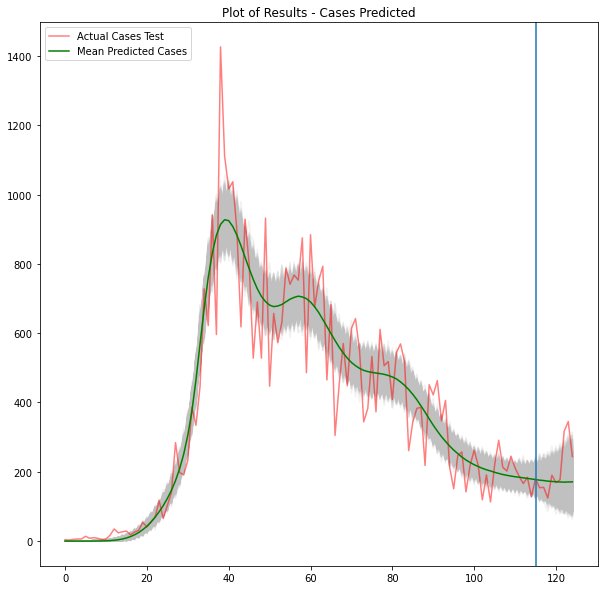

In [677]:
fig, ax = plt.subplots(figsize=(10,10))

#ax.plot(train_local_cases, c='b', label='Local Cases')
#ax.plot(temp_dates, trace_10['Obs_missing'].T, c='silver', alpha=0.2)
ax.plot(ppc_11['Obs'].T, c='silver', alpha=0.2)

ax.plot(np.concatenate([train_local_cases, actual]), c='r', alpha=0.5, label='Actual Cases Test')
ax.plot(ppc_11['Obs'].mean(0), c='g', alpha=1, label='Mean Predicted Cases')
ax.axvline(x=end_date)
ax.set_title("Plot of Results - Cases Predicted")
ax.legend()
plt.show()

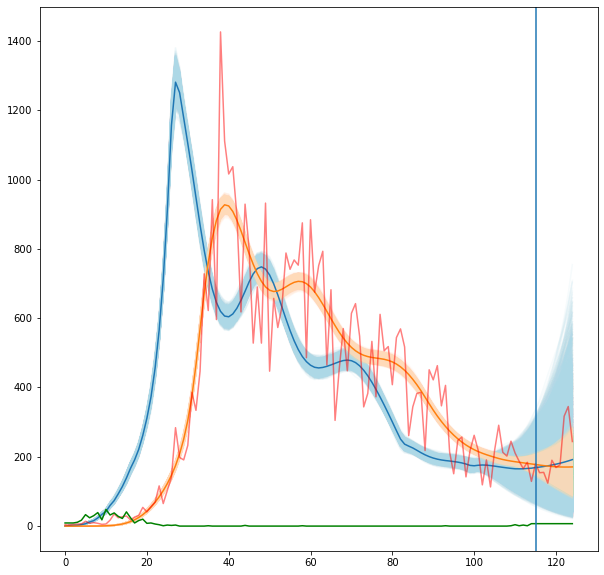

In [678]:
fig, ax = plt.subplots(figsize=(10,10))

ax.plot(trace_11['infections'].T, c='lightblue', alpha=0.1)
ax.plot(trace_11['test_adjusted_positive_jit'].T, c='peachpuff', alpha=0.1)
ax.plot(trace_11['infections'].mean(0))
ax.plot(trace_11['test_adjusted_positive_jit'].mean(0))
ax.plot(np.concatenate([train_local_cases, actual]), c='r', alpha=0.5)
ax.plot(imported_input, c='g')
ax.axvline(x=end_date)

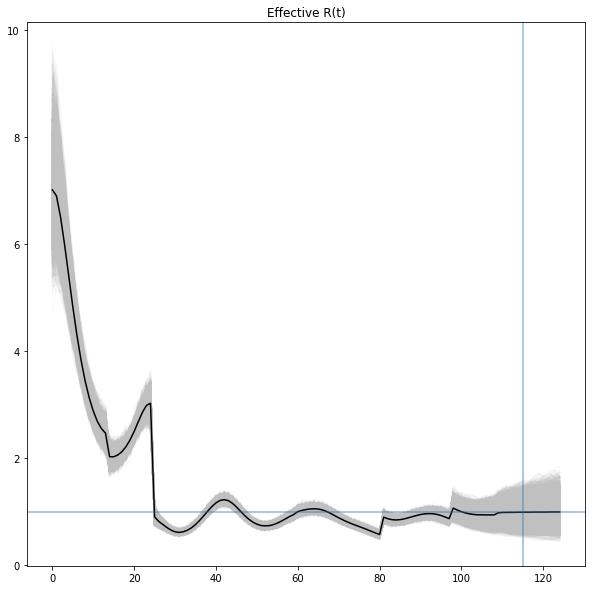

In [679]:
fig, ax = plt.subplots(figsize=(10,10))

ax.plot(trace_11['r_t'].T, c='silver', alpha=0.1)
ax.plot(trace_11['r_t'].mean(0), c='black', alpha=1)
ax.axhline(y=1, alpha=0.5)
ax.axvline(x=end_date, alpha=0.5)
ax.set_title("Effective R(t)")
plt.show()

In [680]:
trace_11.varnames

['log_r_t',
 'b_0',
 'b_1',
 'b_2',
 'b_3',
 'b_4',
 'b_5',
 'b_6',
 'b_7',
 'b_8',
 'b_9',
 'log_eps_t',
 'eps_t_logodds__',
 'Seed_log__',
 'Obs_missing',
 'r_t',
 'eps_t',
 'Seed',
 'infections',
 'test adjusted positive',
 'test_adjusted_positive_jit']

/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


[]

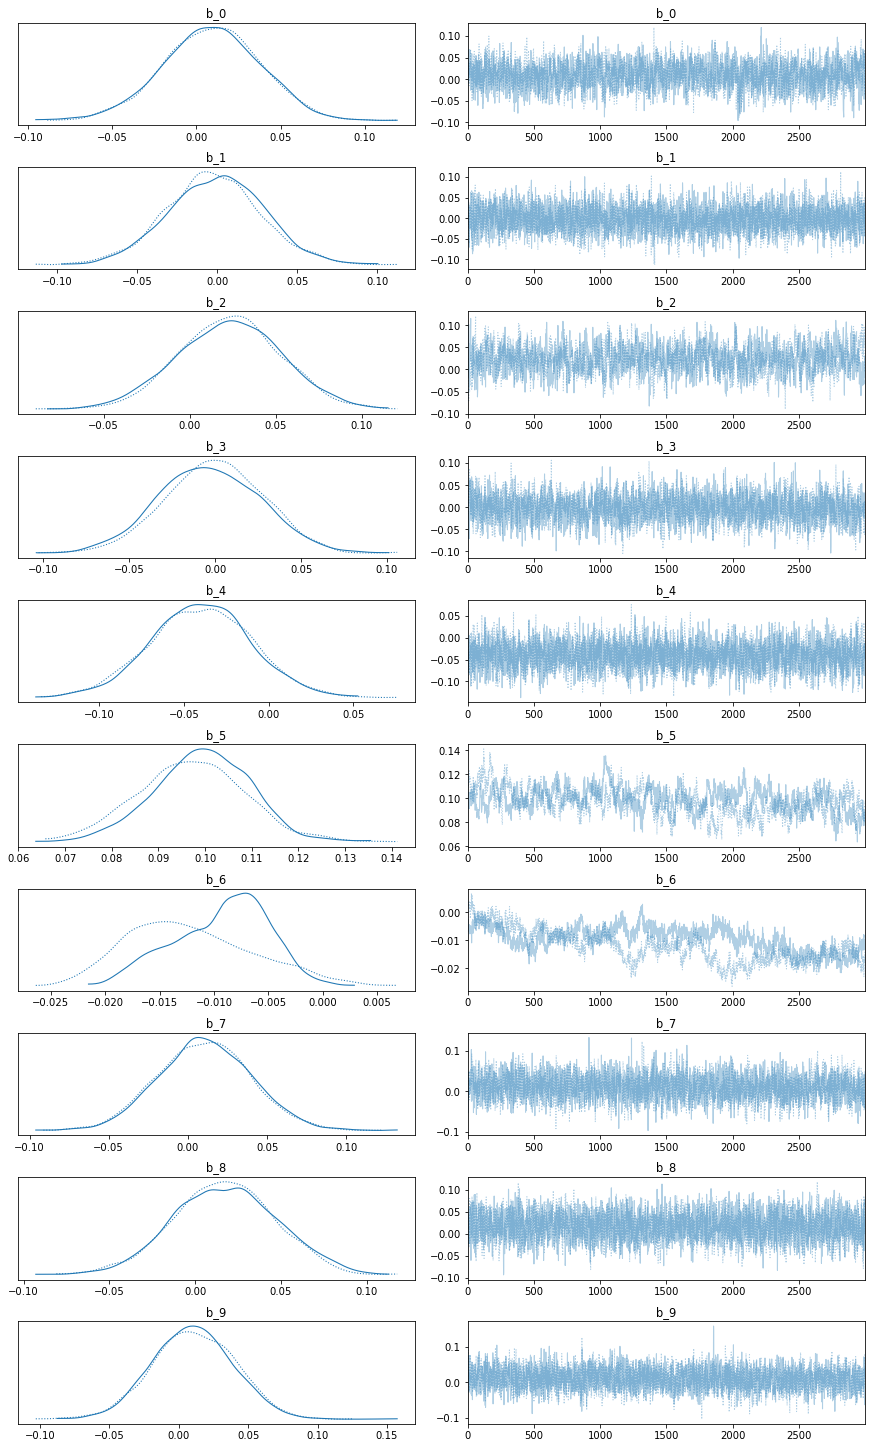

In [681]:
az.plot_trace(trace_11,var_names=['b_'+str(x) for x in range(10)])
plt.plot()

In [682]:
dict(zip(list(NPIS_wanted.columns),['b_'+str(x) for x in range(10)]))

{'Compulsory_Mask': 'b_0',
 'Eat_In_Ban': 'b_1',
 'Entry_Recording': 'b_2',
 'Lockdown': 'b_3',
 'Sch_Closure': 'b_4',
 'Gathering_Max': 'b_5',
 'Mall_Distancing': 'b_6',
 'Recreation': 'b_7',
 'Workplace_Closure': 'b_8',
 'Worship': 'b_9'}

In [683]:
az.summary(trace_11,var_names=['b_'+str(x) for x in range(10)])

/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b_0,0.009,0.029,-0.044,0.064,0.001,0.001,1386.0,2704.0,1.00
b_1,-0.001,0.030,-0.061,0.052,0.001,0.000,2941.0,3642.0,1.00
b_2,0.023,0.030,-0.032,0.079,0.001,0.001,688.0,1501.0,1.00
b_3,-0.002,0.029,-0.057,0.052,0.001,0.001,1363.0,3110.0,1.00
b_4,-0.040,0.030,-0.096,0.016,0.001,0.000,2133.0,3559.0,1.00
b_5,0.098,0.011,0.076,0.117,0.003,0.002,13.0,134.0,1.13
b_6,-0.011,0.005,-0.020,-0.001,0.002,0.002,5.0,29.0,1.34
b_7,0.011,0.029,-0.046,0.063,0.001,0.000,2401.0,3890.0,1.00
b_8,0.017,0.030,-0.036,0.076,0.000,0.000,3757.0,4676.0,1.00
b_9,0.011,0.029,-0.044,0.064,0.001,0.000,2148.0,4287.0,1.01


# Model 12 - Model 10 / 11 without prediction just to see whether same

In [697]:
print("Length import Cases: ",len(imported_cases))
print("Length local Cases: ", len(local_cases))

prediction_t = 0 # Days
end_date = 115

train_local_cases = local_cases[0:end_date]
train_imported_cases = imported_cases[0:end_date]

actual = local_cases[end_date:end_date+prediction_t]

train_pad = [np.nan for x in range(prediction_t)]
imported_pad = [train_imported_cases[-1] for x in range(prediction_t)]

model_input = pd.Series(np.concatenate([train_local_cases, train_pad]))
imported_input = np.concatenate([train_imported_cases, imported_pad])

print("Length training cases: ", len(train_local_cases))
print("Length into model: ", len(model_input)," ",len(imported_input))

len_observed = len(model_input)

NPIS_array = NPIS_wanted.iloc[0:end_date+prediction_t]
NPIS_array.loc[NPIS_array['Gathering_Max']==150,'Gathering_Max'] = 10
NPIS_array = NPIS_array.values
#num_NPIS = NPIS_array.shape[1]
print(NPIS_array.shape)

Length import Cases:  448
Length local Cases:  448
Length training cases:  115
Length into model:  115   115
(115, 10)


/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [777]:
NPIS_array.shape

(115, 10)

In [723]:
convolution_ready_gt = _get_convolution_ready_gt(len_observed)

likelihood_fun = 'PO' # PO or ZINB
with pm.Model() as model_12:
    
    # r0 positive
    log_r_t = pm.GaussianRandomWalk(
        'log_r_t',
        sigma=0.035,
        shape=len_observed)
    
    beta_list = []
    for i in range(num_NPIS):
        beta_list.append(pm.Normal(f"b_{i}", 0, sigma=0.03))
    betas = pm.math.stack(beta_list, 0)
    #beta_intercept = pm.Normal('b_inter', 0, sigma=0.1)
    rt_covariates = pm.math.dot(np.array(NPIS_array), betas)
    
    
    # Form r_t as GRW + covariates
    r_t = pm.Deterministic('r_t', pm.math.exp(log_r_t + rt_covariates))
    
        
    # Imported cases leak percent
    log_eps_t = pm.GaussianRandomWalk(
        'log_eps_t',
        sigma=0.035,
        shape=len_observed)
    #eps_t = pm.Deterministic('eps_t', pm.math.exp(log_eps_t))
    eps_t = pm.Beta('eps_t', alpha=1, beta=1000)
    
    # Seed pop
    seed = pm.Exponential('Seed', 150)  # Scale of infection will be small
    y0 = tt.zeros(len_observed)
    y0 = tt.set_subtensor(y0[0], seed)
    # Apply recursively to populate tensor
    outputs, _ = theano.scan(
            fn=lambda t, gt , i_cases, y, r_t: tt.set_subtensor(y[t], tt.sum(r_t*y*gt) + eps_t * i_cases),
            sequences=[tt.arange(1, len_observed), convolution_ready_gt, theano.shared(imported_input)],
            outputs_info=y0,
            non_sequences=r_t,
            n_steps=len_observed-1,
    )
    
    infections = pm.Deterministic('infections', outputs[-1])
    
    
    
    # Test observation
    t_p_delay = pm.Data("p_delay", p_delay)
    
    test_adjusted_positive = pm.Deterministic(
        "test adjusted positive",
        conv(infections, t_p_delay, len_observed)
    )
    
    # For stability
    test_adjusted_positive_jittered = pm.Deterministic('test_adjusted_positive_jit',
                                                   test_adjusted_positive + 0)
    """
    # Accounts for number of tests 
    # Get number of tests
    tests = pm.Data("tests", tests_performed)
    exposure = pm.Deterministic(
        "exposure",
        pm.math.clip(tests_performed, 1000, 1e9)  # Hard code to 300 test a day for unobs period
    )
    
    positive = pm.Deterministic(
        "positive", exposure * test_adjusted_positive_jittered
    )
    """
    
    # Likelihood
    if likelihood_fun == 'ZINB':
        pm.ZeroInflatedNegativeBinomial('Obs', 
                  mu=test_adjusted_positive_jittered, 
                  alpha=pm.Gamma("alpha", mu=1, sigma=0.5),
                  psi = pm.Beta('psi', 2,2),                    
                  observed=local_cases)    
        
    elif likelihood_fun == 'NB':
        pm.NegativeBinomial('Obs', 
                  mu=test_adjusted_positive_jittered, 
                  alpha=pm.Gamma("alpha", mu=1, sigma=0.5),
                  observed=local_cases)
    
    elif likelihood_fun == 'PO':
        print('hi')
        pm.Poisson('Obs', 
                  mu=test_adjusted_positive_jittered,
                  observed=model_input)
    
    trace_12 = pm.sample(chains=2,
                         tune=2000,
                         draws=4000,
                         target_accept=0.99,
                         init="adapt_diag"
                        )#,nuts={'target_accept':0.99})#, target_accept=0.99)

hi


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [Seed, eps_t, log_eps_t, b_9, b_8, b_7, b_6, b_5, b_4, b_3, b_2, b_1, b_0, log_r_t]


Sampling 2 chains for 2_000 tune and 4_000 draw iterations (4_000 + 8_000 draws total) took 10089 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [724]:
_, n_traces = trace_11['Obs_missing'].T.shape
temp_dates = np.arange(end_date, end_date+prediction_t).reshape(-1,1)
temp_dates = np.tile(temp_dates,n_traces)

In [725]:
with model_12:
    ppc_12 = pm.sample_posterior_predictive(
        trace_12, random_seed=123)

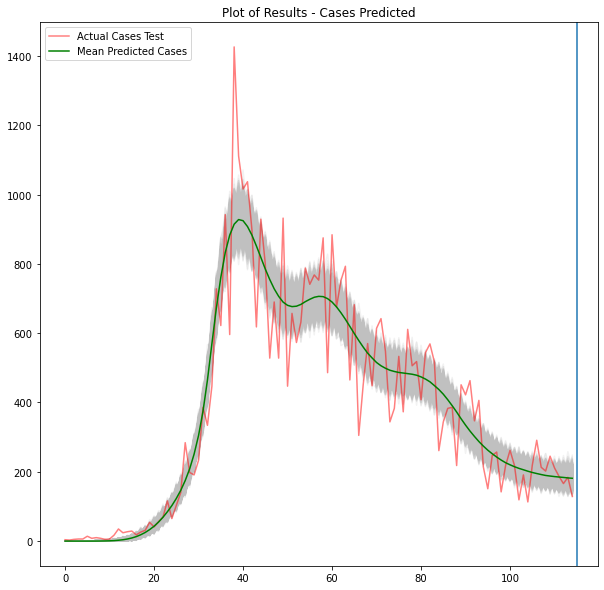

In [726]:
fig, ax = plt.subplots(figsize=(10,10))

#ax.plot(train_local_cases, c='b', label='Local Cases')
#ax.plot(temp_dates, trace_10['Obs_missing'].T, c='silver', alpha=0.2)
ax.plot(ppc_12['Obs'].T, c='silver', alpha=0.2)

ax.plot(np.concatenate([train_local_cases, actual]), c='r', alpha=0.5, label='Actual Cases Test')
ax.plot(ppc_12['Obs'].mean(0), c='g', alpha=1, label='Mean Predicted Cases')
ax.axvline(x=end_date)
ax.set_title("Plot of Results - Cases Predicted")
ax.legend()
plt.show()

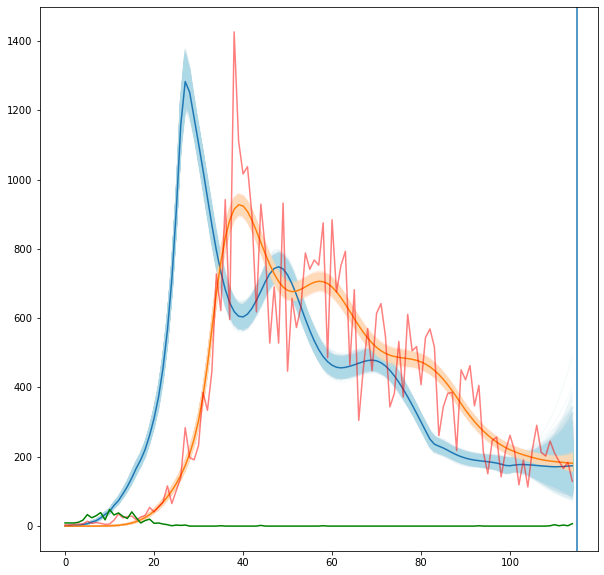

In [727]:
fig, ax = plt.subplots(figsize=(10,10))

ax.plot(trace_12['infections'].T, c='lightblue', alpha=0.1)
ax.plot(trace_12['test_adjusted_positive_jit'].T, c='peachpuff', alpha=0.1)
ax.plot(trace_12['infections'].mean(0))
ax.plot(trace_12['test_adjusted_positive_jit'].mean(0))
ax.plot(np.concatenate([train_local_cases, actual]), c='r', alpha=0.5)
ax.plot(imported_input, c='g')
ax.axvline(x=end_date)

# Model 12.5
- Hierarchical Effects (need to recode NPIs first)
- Sum to become a lockdown index

# Model 13 
- First model with separate infected populations for dormitory cases as well as community cases

# Model 14
- First model to incorporate the effect of quarantine as well as vaccination rates

# Model 15
- Time varying onset - delay and generation times.

# Model 16
- Non deterministic latent infected to account for super spreader events

# Model Comparison

In [250]:
az.compare({
    'Simplest': trace_1,
    'Only Generation Time':trace_2,
    'Generation Time + RT NPI Coavariates': trace_4,
    'Generation Time + RT NPI Coavariates + Zero inflated': trace_5})

/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packa

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Generation Time + RT NPI Coavariates,0,-1570.659773,19.777704,0.000000,9.978604e-01,52.305803,0.000000,False,log
Only Generation Time,1,-1570.998389,19.806806,0.338616,5.104432e-16,52.358256,0.234655,False,log
Generation Time + RT NPI Coavariates + Zero inflated,2,-1572.678688,19.569732,2.018915,0.000000e+00,52.375470,0.263122,True,log
Simplest,3,-2485.798618,1.570142,915.138845,2.139620e-03,64.905321,24.499392,False,log


In [218]:
az.compare({
    '8': trace_8,
    '9 Generation Time':trace_9})

/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-r

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
9 Generation Time,0,-4067.774371,373.320698,0.00000,0.877024,561.862781,0.000000,True,log
8,1,-107067.348142,351.332064,102999.57377,0.122976,4415.565236,4543.822939,True,log


In [239]:
az.compare({
    'Simplest': trace_8,
    'Only Generation Time':trace_2,
    'Generation + Onset': trace_3
})

/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packa

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Only Generation Time,0,-1570.998389,19.806806,0.000000,0.977460,52.358256,0.000000,False,log
Generation + Onset,1,-1572.940396,18.952800,1.942006,0.020307,52.536873,1.637805,False,log
Simplest,2,-2485.798618,1.570142,914.800229,0.002233,64.905321,24.543604,False,log


# Generic Visualization Tools

In [719]:
trace = trace_11
start_id = 0

In [716]:
trace.varnames

['log_r_t',
 'b_0',
 'b_1',
 'b_2',
 'b_3',
 'b_4',
 'b_5',
 'b_6',
 'b_7',
 'b_8',
 'b_9',
 'log_eps_t',
 'eps_t_logodds__',
 'Seed_log__',
 'r_t',
 'eps_t',
 'Seed',
 'infections',
 'test adjusted positive',
 'test_adjusted_positive_jit']

In [717]:
data_subset = data.iloc[start_id::,:]
data_subset['t'] = range(len_observed)
phase_info = data_subset[['Phase', 't']]

def get_intervals(days_in_phase):

    interval_track = []
    cnt = 0
    c = days_in_phase['t'].iloc[0]
    start = c

    for i in range(len(days_in_phase)):

        if days_in_phase['t'].iloc[cnt] != c:

            interval_track.append((start, days_in_phase['t'].iloc[cnt-1]))
            c = days_in_phase['t'].iloc[cnt]  # reset c
            start = c

        c += 1 
        cnt += 1

    interval_track.append((start, days_in_phase['t'].iloc[cnt-1]))
    
    return interval_track

phase_times = {}
for ph in phase_info['Phase'].unique():
    if pd.isna(ph):
        continue
    
    else: 
        days_in_phase = phase_info[phase_info['Phase']==ph]
        
        # Check if disjoint
        days_elapsed = days_in_phase['t'].iloc[-1] - days_in_phase['t'].iloc[0] +1
        
        if days_elapsed == len(days_in_phase):
            # Not disjoint
            start = days_in_phase['t'].iloc[0]
            end = days_in_phase['t'].iloc[-1]
            phase_times[ph] = [(start, end)]
        
        else: 
            phase_times[ph] = get_intervals(days_in_phase)
            

ValueError: Length of values (115) does not match length of index (498)

/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


<AxesSubplot:>

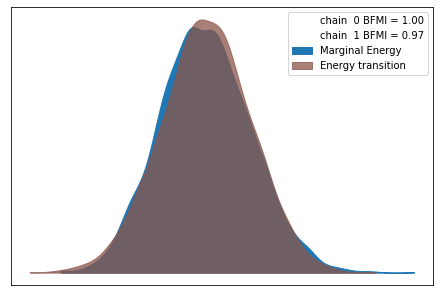

In [720]:
az.plot_energy(trace)

In [222]:
col_list = ['red','blue','green','orange','purple']
phase_times


{'Circuit Breaker': [(25, 80)],
 'Phase 1': [(81, 97)],
 'Phase 2': [(98, 289), (421, 428)],
 'Phase 3': [(290, 420)],
 'Phase 2 (Heightened Alert)': [(429, 447)]}

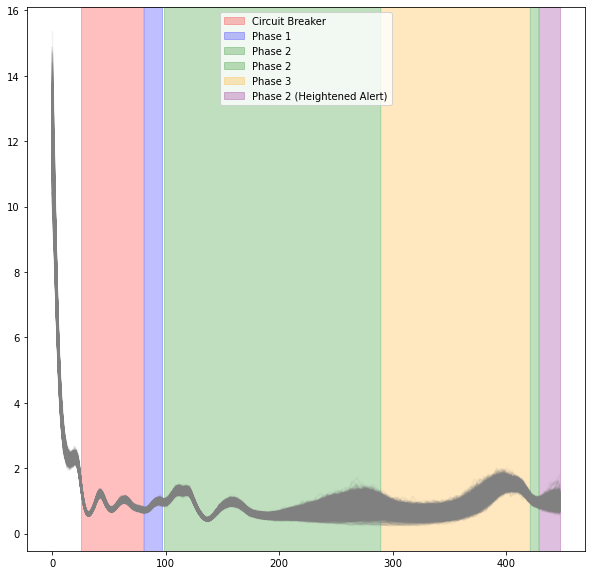

In [223]:
post_rt = trace.get_values('r_t', burn=0, chains=[0])
post_rt = pd.DataFrame(post_rt.T)

fig, ax = plt.subplots(figsize=(10,10))

ax.plot(post_rt, color='0.5', alpha=0.1)

for col, ph in enumerate(phase_times.keys()):
    p_time = phase_times[ph]
    
    for times in p_time:
        ax.axvspan(times[0], times[1],
                   color=col_list[col],
                   alpha=0.25,
                   label=ph)
ax.legend()
plt.show()

/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/pymc3/sampling.py:1688: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


[]

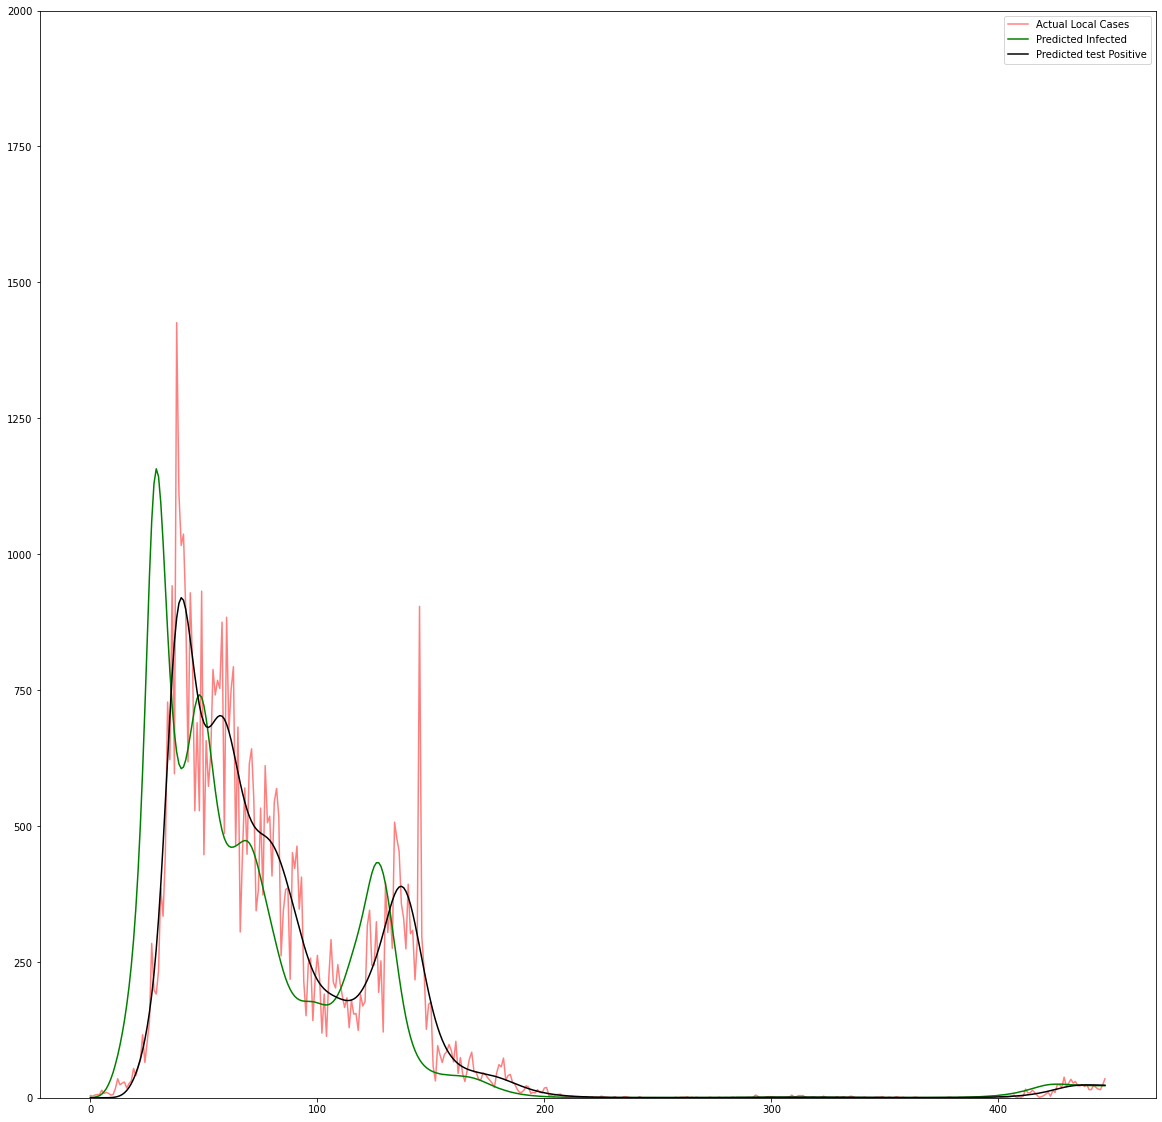

In [225]:
with model_9:
    post_pred_r_t = pm.sample_posterior_predictive(trace,
                                                   samples=1000)

SHOW_PHASES = False
SCALE = False 
fig, ax = plt.subplots(figsize=(20,20))

if SCALE:
    #ax.plot(post_pred_r_t['Obs'].T, color='0.5', alpha=0.02)
    ax.plot(local_cases, color='r', label='Actual Local Cases', alpha=0.5)
    ax.plot(scale_to_positives(local_cases, trace['infections'].mean(0)), color='g', label='Predicted Infected')
    #ax.plot(trace['positive'].mean(0), color='b', label='Predicted Constant test Positive')
    ax.plot(scale_to_positives(local_cases, trace['test adjusted positive'].mean(0)), color='k', label='Predicted test Positive')

else:
    #ax.plot(post_pred_r_t['Obs'].T, color='0.5', alpha=0.02)
    ax.plot(local_cases, color='r', label='Actual Local Cases', alpha=0.5)
    ax.plot(trace['infections'].mean(0), color='g', label='Predicted Infected')
    #ax.plot(trace['positive'].mean(0), color='b', label='Predicted Constant test Positive')
    ax.plot(trace['test adjusted positive'].mean(0), color='k', label='Predicted test Positive')

if SHOW_PHASES:
    for col, ph in enumerate(phase_times.keys()):
        p_time = phase_times[ph]

        for times in p_time:
            ax.axvspan(times[0], times[1],
                       color=col_list[col],
                       alpha=0.15,
                       label=ph)
ax.legend()
ax.set_ylim([0,2000])
plt.plot()

<AxesSubplot:>

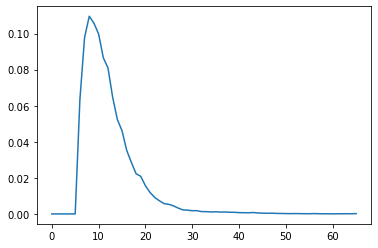

In [80]:
p_delay.plot()

In [208]:
p_delay

0     0.000100
1     0.000100
2     0.000100
3     0.000100
4     0.000100
        ...   
61    0.000078
62    0.000098
63    0.000117
64    0.000078
65    0.000163
Name: p_delay, Length: 66, dtype: float64

In [78]:
local_cases[50:]

array([447, 657, 573, 632, 788, 741, 768, 753, 875, 486, 884, 675, 752,
       793, 465, 682, 305, 451, 570, 448, 614, 642, 548, 344, 383, 533,
       373, 611, 506, 518, 408, 544, 569, 517, 261, 344, 383, 386, 218,
       451, 422, 463, 347, 406, 214, 151, 247, 257, 142, 218, 262, 218,
       119, 191, 113, 219, 291, 213, 202, 245, 211, 187, 166, 184, 129,
       180, 154, 155, 124, 190, 169, 177, 317, 345, 244, 244, 324, 194,
       252, 121, 396, 304, 349, 275, 507, 477, 454, 357, 330, 274, 393,
       302, 308, 217, 288, 904, 297, 236, 126, 172, 176,  58,  31,  96,
        79,  65,  80,  85,  98,  87,  66, 104,  45,  74,  44,  30,  50,
        72,  84,  48,  47,  34,  33,  46,  43,  37,  32,  27,  19,  46,
        61,  57,  73,  32,  41,  43,  28,  25,  16,  10,  10,  14,  22,
        20,   8,  10,   9,  15,  10,   9,  18,  19,   4,   5,   2,   6,
         6,   7,   4,   4,   1,   2,   3,   2,   0,   2,   1,   1,   2,
         2,   0,   2,   0,   1,   0,   3,   2,   1,   1,   0,   

In [554]:
tests_performed

array([    0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
      

In [468]:
scale_to_positives(local_cases, trace['infections'].mean(0))[0]

15411.805545775449

# If Covariates

In [253]:
az.summary(trace,[ 'b_0',
 'b_1',
 'b_2',
 'b_3',
 'b_4',
 'b_inter'])

/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b_0,-0.006,0.030,-0.061,0.054,0.001,0.001,1840.0,1469.0,1.0
b_1,-0.011,0.029,-0.070,0.040,0.001,0.001,2322.0,1862.0,1.0
b_2,0.019,0.030,-0.036,0.076,0.001,0.001,891.0,1211.0,1.0
b_3,-0.015,0.030,-0.070,0.041,0.001,0.001,2603.0,1362.0,1.0
b_4,0.004,0.029,-0.052,0.056,0.001,0.001,1835.0,1697.0,1.0
b_inter,-0.000,0.030,-0.059,0.054,0.002,0.001,317.0,565.0,1.0


In [252]:
trace.varnames

['log_r_t',
 'b_0',
 'b_1',
 'b_2',
 'b_3',
 'b_4',
 'b_inter',
 'Seed_log__',
 'alpha_log__',
 'r_t',
 'Seed',
 'infections',
 'alpha']

In [451]:
import pymc3 as pm
import pandas as pd
import numpy as np
import arviz as az
from matplotlib import pyplot as plt
from covid.models.generative import GenerativeModel
from covid.data import summarize_inference_data
%config InlineBackend.figure_format = 'retina'

from covid.data import get_and_process_covidtracking_data, summarize_inference_data

In [452]:
df = get_and_process_covidtracking_data(run_date=pd.Timestamp.today()-pd.Timedelta(days=1))

In [453]:


region = "OR"
model_data = df.loc[region]



<AxesSubplot:xlabel='date'>

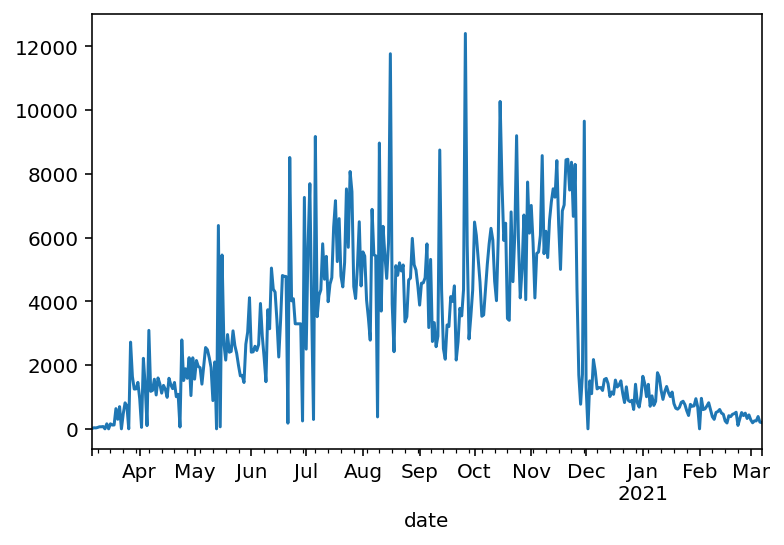

In [457]:
model_data['total'].plot()

In [461]:
gm = GenerativeModel(region, model_data)
gm.sample()

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 700 tune and 200 draw iterations (2_800 + 800 draws total) took 1577 seconds.


0, dim: nonzero_date, 358 =? 358


In [76]:
def scale_to_positives(positive_cases, data):
    
    """ Scales a time series to have the same mean as the observed positives
        time series. This is useful because many of the series we infer are
        relative to their true values so we make them comparable by putting
        them on the same scale. """
    
    scale_factor = positive_cases.mean() / np.mean(data)
    return scale_factor * data